In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../../plankton'))

In [2]:
import plankton as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data_folder='data/'

umpp=0.152

coordinates = pd.read_csv(os.path.join(data_folder,'./coordinates_joined.csv'))
mask = ~coordinates.gene.isin(['CGA','KISS1'])
mask[np.random.uniform(size=mask.size)<0.3]=True

dapi_image = plt.imread(os.path.join(data_folder,'156KS_FITC_backround.tif')).sum(-1)
dapi_image -=dapi_image.min()
dapi_image = 1-(dapi_image/dapi_image.max())**0.7

# bg_cells= np.load('./data/leftCA1/label_image.coo.npz')
# cell_mask = np.zeros(bg_cells['shape'])
# cell_mask[bg_cells['row'],bg_cells['col']]=bg_cells['data']

In [4]:
sdata = pl.SpatialData(genes=coordinates.gene,
                       x_coordinates=coordinates.X*umpp,
                       y_coordinates=coordinates.Y*umpp-35,
                      pixel_maps=[pl.PixelMap(dapi_image,upscale=0.25/umpp),])[mask]

(<matplotlib.collections.PathCollection at 0x7fc82cd15fa0>, None, None)

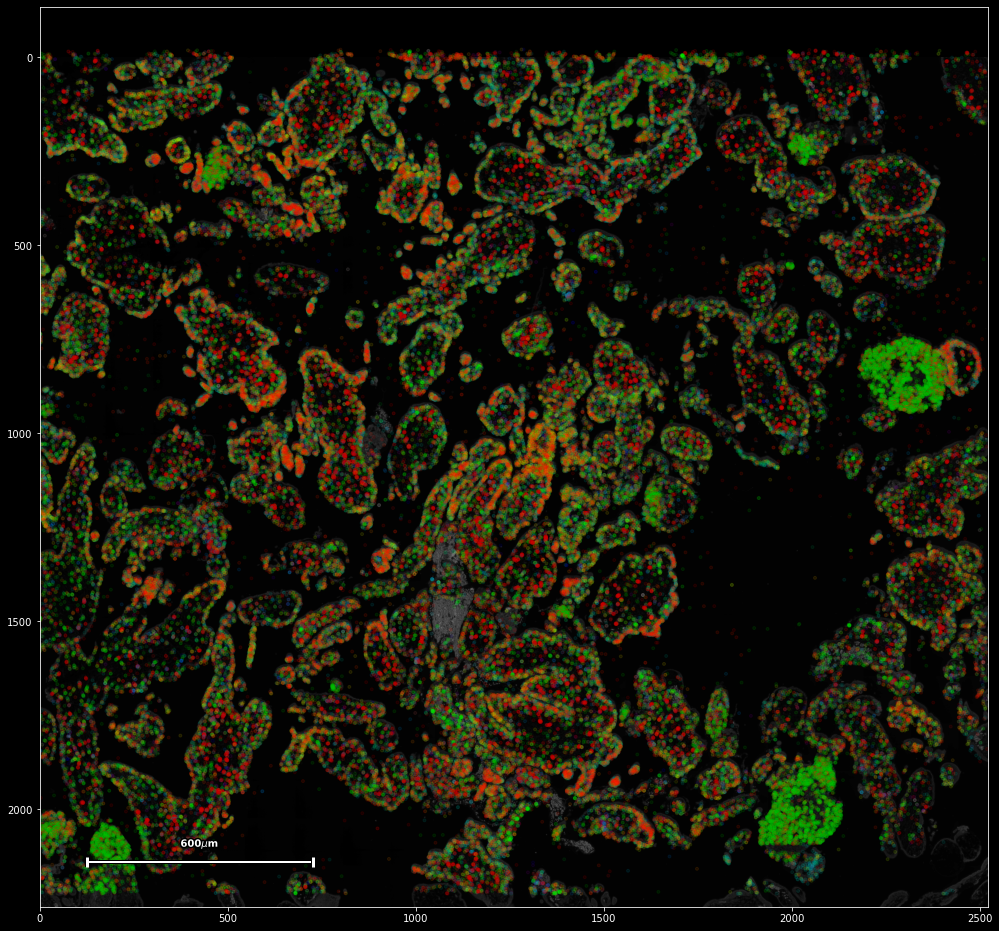

In [5]:
plt.figure(figsize=(17,17))
sdata.scatter(alpha=0.1,marker='.')

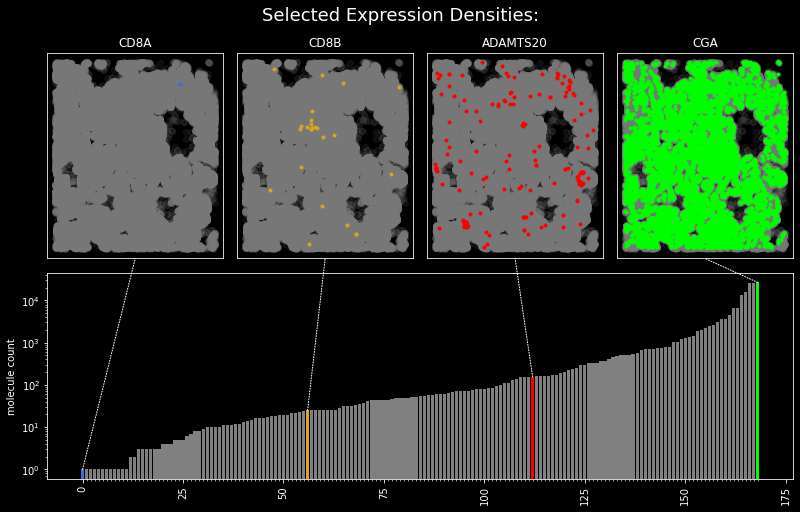

In [6]:
sdata.plot_overview()

In [12]:
knn_neighbors=160
bandwidth=5
n_neighbors=30
metric='euclidean'
min_dist=0.03
random_state=42
zero_weight=2
zero_weight=0

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)

sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)



<IPython.core.display.Javascript object>


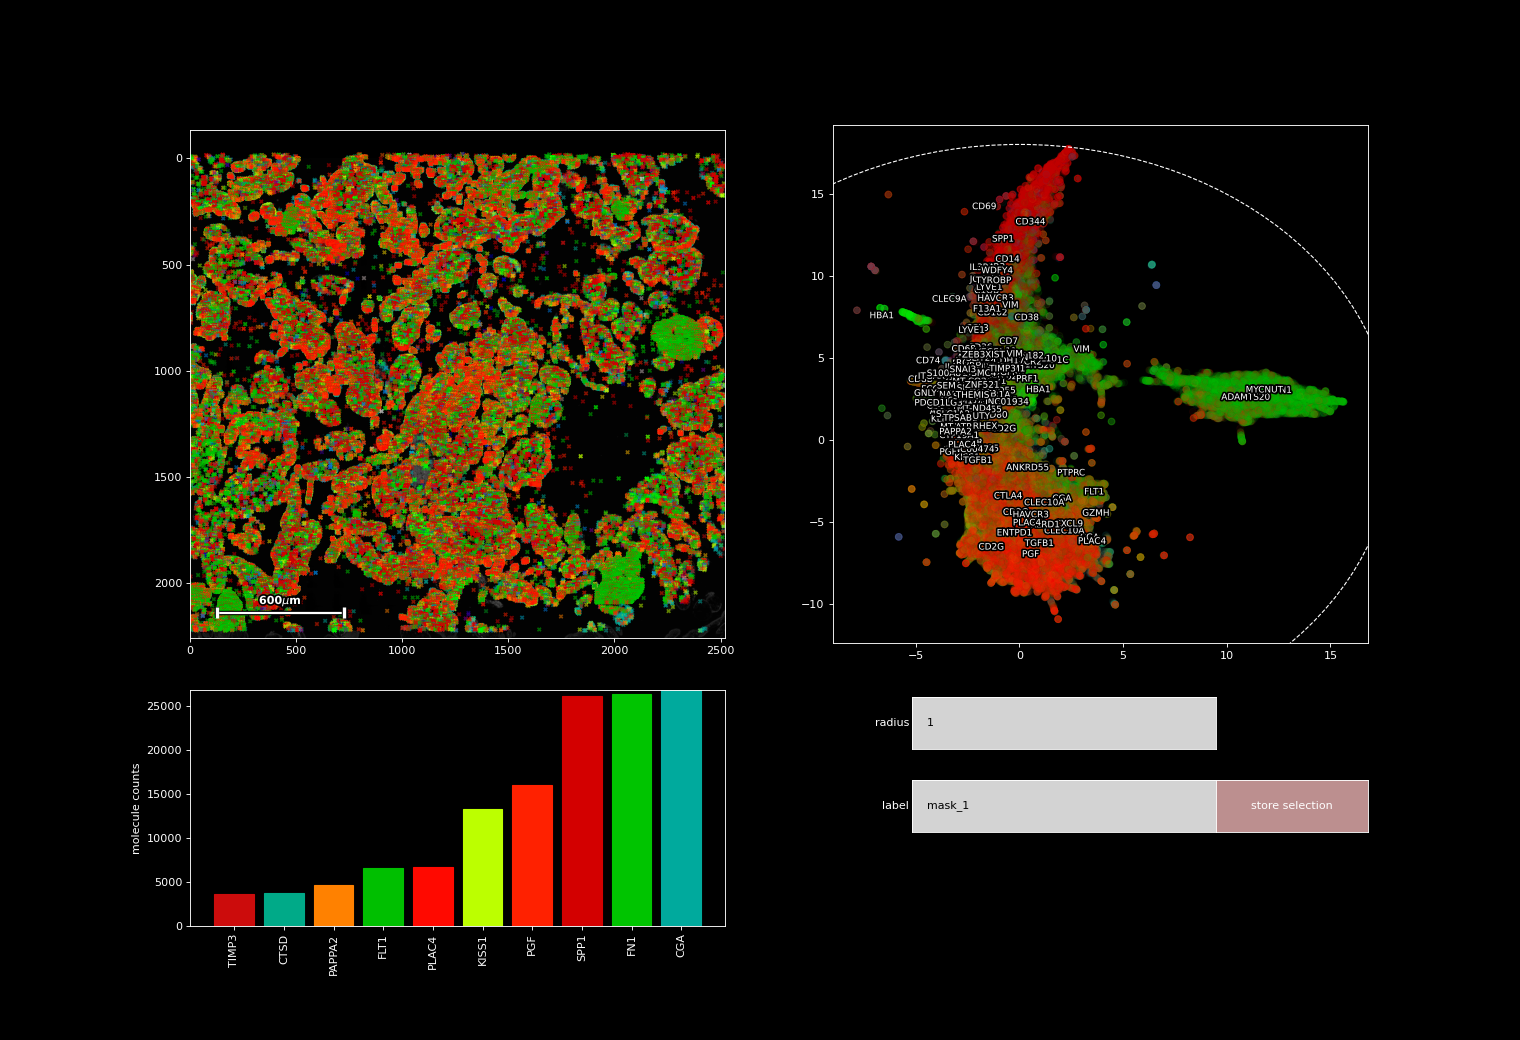

In [13]:
%matplotlib notebook

plt.style.use('dark_background')

plt.figure(figsize=(19,13))
sdata.graph.umap_interactive(color_prop='genes',umap_kwargs={'alpha':0.05,'thlds_text':[0.8,0.03,200],'text_distance':1.5,'legend':False,'text_kwargs':{'fontsize':8},'text_prop':'genes'})

<IPython.core.display.Javascript object>


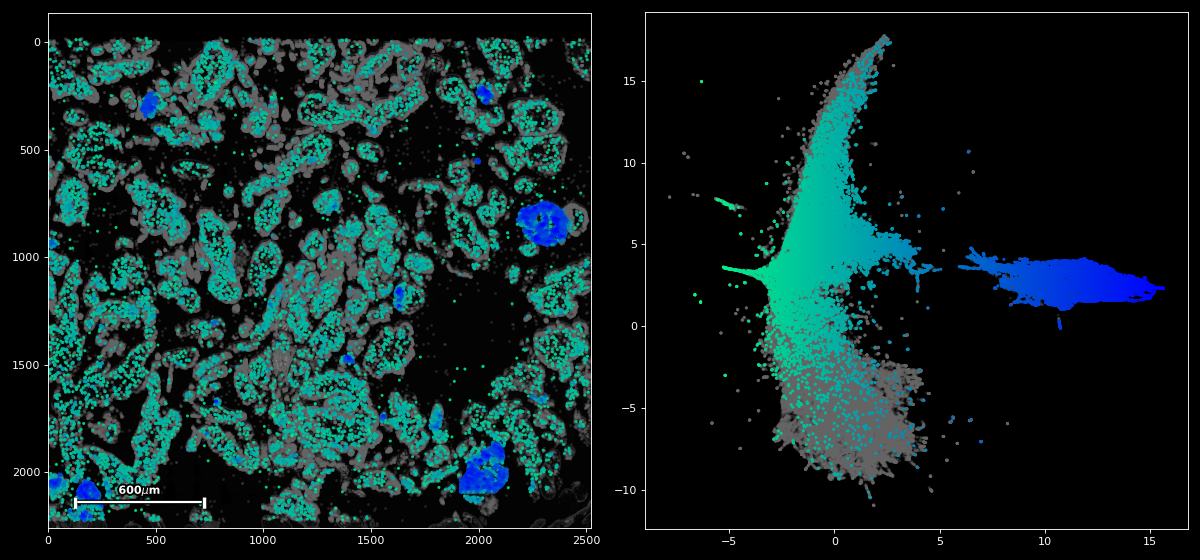

In [14]:
plt.figure(figsize=(15,7))

clr = 'dimgrey'
cmap = 'winter'
plt.subplot(121)
sdata[sdata.g!='FN1'].scatter(color=clr,s=3,alpha=0.2)
sdata[sdata.g=='FN1'].scatter(c=-sdata[sdata.g=='FN1'].graph.umap[:,0],alpha=0.8,cmap=cmap,s=3)

plt.subplot(122)
sdata[sdata.g!='FN1'].graph.plot_umap(color=clr,s=3,alpha=0.2)
sdata[sdata.g=='FN1'].graph.plot_umap(c=-sdata[sdata.g=='FN1'].graph.umap[:,0],cmap=cmap,s=3)

plt.tight_layout()

In [15]:
import plotly.express as px
from scipy.stats import binom

import plotly.graph_objects as go
from ipywidgets import widgets, interactive, HBox, VBox,Output,Layout

import pandas as pd

n_bars=20

f_scatter = go.FigureWidget(px.imshow(np.repeat(sdata.pixel_maps[0].data[:,:,None],3,axis=-1,),
                          x=np.linspace(sdata.background.extent[0],sdata.background.extent[1],sdata.background.data.shape[0]),
                         y=np.linspace(sdata.background.extent[2],sdata.background.extent[3],sdata.background.data.shape[1])
                         ),
                layout=Layout(border='solid 4px',width='100%'))

trace_scatter=go.Scattergl(x=sdata.x,
                           y=sdata.y,
                           mode='markers', 
                           marker=dict(color=sdata.obsc.project('c_genes')),
                           hoverinfo='none',meta={'name':'tissue-scatter'},
                           unselected={'marker':{'color':'black','opacity':0.2}},
                          )

f_scatter.add_trace(trace_scatter)

f_umap = go.FigureWidget(go.Scattergl(x=sdata.graph.umap[:,0],
                                      y=sdata.graph.umap[:,1],
                                      mode='markers', 
                                      marker=dict(color=sdata.obsc.project('c_genes')),
                                       unselected={'marker':{'color':'black','opacity':0.2}},
                                      hoverinfo='none',meta={'name':'umap-scatter'}),
                        )

colors=sdata.obsc.loc[sdata.stats.sort_values('counts')[-n_bars:].index,'c_genes'].values

w_bars=go.Bar(                  x=sdata.stats.sort_values('counts')[-n_bars:].index,
                                y=sdata.stats.sort_values('counts')[-n_bars:]['counts'],
                                marker={'color':['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]},
                               )
f_bars = go.FigureWidget(w_bars)

f_bars.data[0]['showlegend']=False



w_bars_ratio_up=go.Bar(         x=sdata.stats.sort_values('counts')[-n_bars:].index,
                                y=[0]*n_bars,
                                marker={'color':['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]},
                               )
f_bars_ratio_up = go.FigureWidget(w_bars_ratio_up)

f_bars_ratio_up.data[0]['showlegend']=False



w_bars_binom=go.Bar(         x=sdata.stats.sort_values('counts')[-n_bars:].index,
                                y=[0]*n_bars,
                                marker={'color':['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]},
                               )
f_bars_binom = go.FigureWidget(w_bars_binom)

f_bars_binom.data[0]['showlegend']=False

out = widgets.Output(layout={'border': '1px solid black'})

def update_bars(plot,points,selector):
    
    if plot['meta']['name']=='tissue-scatter':
        f_umap.data[0].selectedpoints=plot.selectedpoints
        
    else:
        f_scatter.data[1].selectedpoints=plot.selectedpoints
        
    subset=sdata[np.array(points.point_inds)]
    
    colors=subset.obsc.loc[subset.stats.sort_values('counts')[-n_bars:].index,'c_genes'].values
    colors=['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]
    ys = subset.stats.sort_values('counts')[-n_bars:]['counts']
    xs = subset.stats.sort_values('counts')[-n_bars:].index
    
    f_bars.data[0].marker.color=colors
    f_bars.data[0].x=xs
    f_bars.data[0].y=ys
    
    vals= (subset.stats.counts)/ (sdata.stats.loc[subset.stats.index].counts)
    idcs = np.argsort(vals)
    
    colors=subset.obsc['c_genes'][idcs]
    colors=['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]
    ys = vals[idcs]
    xs = subset.stats.index[idcs]
    
    f_bars_ratio_up.data[0].marker.color=colors[-n_bars:]
    f_bars_ratio_up.data[0].x=xs[-n_bars:]
    f_bars_ratio_up.data[0].y=(ys[-n_bars:])
    
    vals= binom.cdf(subset.stats.counts,sdata.stats.loc[subset.stats.index].counts,len(subset)/len(sdata))
    idcs = np.argsort(vals)
    
    colors=subset.obsc['c_genes'][idcs]
    colors=['rgb'+str(tuple((np.array(c)*256).astype(int))) for c in  colors]
    ys = vals[idcs]
    xs = subset.stats.index[idcs]
    
    f_bars_binom.data[0].marker.color=colors[-n_bars:]
    f_bars_binom.data[0].x=xs[-n_bars:]
    f_bars_binom.data[0].y=(ys[-n_bars:])
    
    
    
f_scatter.data[1].on_selection(update_bars)
f_umap.data[0].on_selection(update_bars)

text_field=widgets.Text(
    value='selection1',
    placeholder='Label for storing',
    description='Name:',
    disabled=False
)

store_button = widgets.Button(
    description='store selection',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)
    
def store_selection(event):
    sdata[text_field.value]=pd.Series(np.arange(len(sdata))).isin(f_umap.data[0].selectedpoints)
    []
store_button.on_click(store_selection)
    
reset_button = widgets.Button(
    description='reset selection',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)


fig = widgets.VBox([widgets.HBox([f_scatter,f_umap] ,layout=Layout(display='flex',width='100%',height='80%',border='red solid 1px',align_items='stretch',justify_content='space-around',flex_direction='row')),
                    widgets.HBox([widgets.HBox([f_bars,f_bars_ratio_up,f_bars_binom],layout=Layout(display='flex',width='80%')),
                                  widgets.VBox([widgets.HBox([text_field,
                                                              store_button
                                                             ]),widgets.HBox([reset_button])],layout=Layout(display='flex',width='20%',height='100%',border='red solid 1px',justify_content='space-around',flex_direction='column')
                                              )]
                                )]
                   
                   ,layout=Layout(width='100%',height='80vh',background='red',border='solid 1px'))


In [16]:
fig

    'data': [{'dx': 0.6081636608344549,
              'dy': 0.608…